# 🔥 AI-Based Thermal Powerline Hotspot Detection
## State-of-the-Art Physics-Informed Machine Learning (PIML)

---

### 📋 Project Overview
This notebook implements a **production-ready, statistically rigorous** anomaly detection system for identifying thermal hotspots in power lines and transmission towers using drone-based thermal inspection data.

### 🎯 Objectives
1. Understand thermal indicators for power infrastructure inspection
2. Apply machine learning to detect thermal anomalies
3. Evaluate model reliability using appropriate metrics
4. Generate spatial risk visualizations for inspection planning

### 🔬 Key Innovations
- **Physics-Informed Features**: Engineering features based on Joule's Law (I²R heating)
- **Bayesian Optimization**: Intelligent hyperparameter search using Optuna
- **Safety-Critical Metrics**: F2-Score prioritizing Recall over Precision
- **Explainable AI**: Transparent feature importance analysis

---

## 1. Environment Setup & Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    fbeta_score, make_scorer, recall_score, precision_score, f1_score,
    precision_recall_curve
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

print("✅ All libraries loaded successfully.")

C:\Users\aviru\Virtual_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All libraries loaded successfully.


### 📝 Interpretation: Library Selection

| Library | Purpose |
|---------|----------|
| **XGBoost** | SOTA gradient boosting for tabular data |
| **Optuna** | Bayesian hyperparameter optimization (smarter than GridSearch) |
| **Statsmodels** | VIF calculation for multicollinearity detection |
| **Scikit-learn** | ML utilities, metrics, calibration |

> **Why XGBoost?** For structured/tabular data, gradient boosting methods consistently outperform deep learning in terms of accuracy, training speed, and interpretability.

---
## 2. Data Loading & Exploration

In [2]:
# Load the thermal inspection dataset
df = pd.read_excel("Thermal Powerline Dataset.xlsx")

print("=== Dataset Overview ===")
print(f"Shape: {df.shape[0]} tiles × {df.shape[1]} features")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nTarget Distribution:")
print(df['fault_label'].value_counts())
print(f"\nClass Imbalance Ratio: {df['fault_label'].value_counts()[0] / df['fault_label'].value_counts()[1]:.2f}:1")
df.head()

=== Dataset Overview ===
Shape: 6000 tiles × 9 features

Columns: ['temp_mean', 'temp_max', 'temp_std', 'delta_to_neighbors', 'hotspot_fraction', 'edge_gradient', 'ambient_temp', 'load_factor', 'fault_label']

Target Distribution:
fault_label
0    3887
1    2113
Name: count, dtype: int64

Class Imbalance Ratio: 1.84:1


,temp_mean,temp_max,temp_std,delta_to_neighbors,hotspot_fraction,edge_gradient,ambient_temp,load_factor,fault_label
0,15.551703,29.588530,3.119858,-2.633301,0.235083,0.852394,17.289249,0.369457,0
1,40.658826,39.218261,6.388712,4.302309,0.158393,1.321425,38.397564,0.685185,0
2,26.919849,32.873410,3.195176,3.145530,0.242524,1.199511,28.152277,0.357874,0
3,34.785930,42.710556,5.513932,5.858629,0.175205,0.688036,36.703955,0.500022,0
4,62.188449,71.188090,5.550522,5.928670,0.233100,0.596020,44.339685,0.989900,1


### 📝 Interpretation: Dataset Understanding

**What the data represents:**
- Each row = one spatial **tile** from drone thermal imagery along a power corridor
- Features are **pre-extracted statistics** (not raw images)

**Feature Meanings:**
| Feature | Physical Meaning |
|---------|------------------|
| `temp_mean` | Average temperature in the tile |
| `temp_max` | Maximum (hottest) temperature |
| `temp_std` | Temperature variation (uniformity indicator) |
| `delta_to_neighbors` | Temperature difference vs adjacent tiles |
| `hotspot_fraction` | % of tile above hotspot threshold |
| `edge_gradient` | Sharpness of thermal boundaries |
| `ambient_temp` | Environmental air temperature |
| `load_factor` | Current load on the line (0-1) |

**Key Observation: Class Imbalance**
> The dataset has more normal tiles than faults. This is typical in anomaly detection - faults are rare. We must handle this carefully to avoid a model that just predicts "Normal" for everything.

---
## 3. Physics-Informed Feature Engineering

### 🔬 The Physics of Electrical Heating (Joule's Law)

Power dissipated as heat in a conductor:
$$P = I^2 R$$

Where:
- $P$ = Power (heat)
- $I$ = Current
- $R$ = Resistance

A **healthy** wire heats proportionally to load. A **faulty** wire (corroded joint, loose connection) has *extra* resistance, causing *unexpected* heating.

In [3]:
epsilon = 1e-3  # Small constant to prevent division by zero

# Feature 1: Temperature Rise Above Ambient
# Why: Absolute temp depends on weather; RELATIVE temp indicates internal heat
df['delta_T'] = df['temp_max'] - df['ambient_temp']

# Feature 2: Load-Normalized Thermal Severity (Joule's Law Proxy)
# Why: High temp at HIGH load is normal. High temp at LOW load is suspicious.
df['load_norm_severity'] = df['delta_T'] / (df['load_factor']**2 + epsilon)

# Feature 3: Thermal Gradient Intensity
# Why: Hotspots create sharp temperature gradients; gradual heating = normal
df['thermal_gradient_intensity'] = df['edge_gradient'] * df['temp_std']

# Feature 4: Relative Hotspot Density
# Why: Normalizes hotspot fraction by overall temperature
df['relative_hotspot'] = df['hotspot_fraction'] * df['temp_max'] / (df['temp_mean'] + epsilon)

# Feature 5: Spatial Anomaly Z-Score
# Why: A tile significantly hotter than neighbors is more suspicious
df['neighbor_zscore'] = (df['delta_to_neighbors'] - df['delta_to_neighbors'].mean()) / df['delta_to_neighbors'].std()

# Feature 6: Thermal Efficiency
# Why: Heat per unit load - higher means less efficient (potential fault)
df['thermal_efficiency'] = df['temp_mean'] / (df['load_factor'] + epsilon)

print("✅ 6 Physics-Informed Features Created")
print(df[['delta_T', 'load_norm_severity', 'thermal_gradient_intensity', 
          'relative_hotspot', 'neighbor_zscore', 'thermal_efficiency']].describe().round(2))

✅ 6 Physics-Informed Features Created
       delta_T  load_norm_severity  thermal_gradient_intensity  \
count  6000.00             6000.00                     6000.00   
mean     10.52               28.80                        4.27   
std       9.23               34.29                        2.32   
min     -18.98             -155.73                        0.44   
25%       4.13                9.85                        2.49   
50%       9.64               22.69                        3.86   
75%      16.20               40.09                        5.74   
max      54.02              358.55                       12.41   

       relative_hotspot  neighbor_zscore  thermal_efficiency  
count           6000.00          6000.00             6000.00  
mean               0.44             0.00               58.81  
std                0.24             1.00               25.55  
min                0.00            -3.62                7.86  
25%                0.26            -0.66            

### 📝 Interpretation: Physics Features

**Why these features matter:**

1. **`load_norm_severity`** (Most Important)
   - Divides temperature rise by load²
   - A wire at 50% load that's as hot as one at 100% load has *double* the resistance → fault
   - This is the mathematical formulation of Joule's Law (I²R)

2. **`delta_T`**
   - On a 40°C day, a 60°C wire has ΔT=20°C
   - On a 20°C day, the same wire would have ΔT=40°C
   - Normalizing for ambient allows cross-season comparisons

3. **`neighbor_zscore`**
   - If ALL tiles are 80°C → heavy load, probably OK
   - If ONE tile is 80°C and neighbors are 40°C → localized fault

> **Key Insight**: Raw temperature alone is misleading. A 70°C reading could be normal (heavy load, hot day) or critical (light load, cool day). Physics-informed features capture the *context*.

---
## 4. Multicollinearity Analysis (VIF)

In [4]:
all_features = [
    'temp_mean', 'temp_max', 'temp_std', 'delta_to_neighbors',
    'hotspot_fraction', 'edge_gradient', 'ambient_temp', 'load_factor',
    'delta_T', 'load_norm_severity', 'thermal_gradient_intensity',
    'relative_hotspot', 'neighbor_zscore', 'thermal_efficiency'
]

X_all = df[all_features]
scaler_vif = StandardScaler()
X_scaled_vif = pd.DataFrame(scaler_vif.fit_transform(X_all), columns=all_features)

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

vif_df = calculate_vif(X_scaled_vif)
print("=== Variance Inflation Factor (VIF) Analysis ===")
print("Interpretation: VIF > 10 = Severe multicollinearity")
print("               VIF > 5  = Moderate multicollinearity\n")
print(vif_df.to_string(index=False))

=== Variance Inflation Factor (VIF) Analysis ===
Interpretation: VIF > 10 = Severe multicollinearity
               VIF > 5  = Moderate multicollinearity

                   Feature       VIF
                  temp_max       inf
        delta_to_neighbors       inf
              ambient_temp       inf
                   delta_T       inf
           neighbor_zscore       inf
                 temp_mean 28.232993
          relative_hotspot 27.361865
          hotspot_fraction 25.824890
thermal_gradient_intensity 16.365648
        thermal_efficiency 12.135352
             edge_gradient 10.702791
               load_factor  6.994123
                  temp_std  6.737311
        load_norm_severity  3.686928


### 📝 Interpretation: VIF Results

**What is VIF?**
- Variance Inflation Factor measures how much a feature's variance is "inflated" due to correlation with other features
- VIF = 1: No correlation with others
- VIF > 10: This feature can be almost perfectly predicted from others → redundant

**Why remove high-VIF features?**
1. **Unstable coefficients**: Small data changes cause large model changes
2. **Misleading importance**: Importance gets "split" between correlated features
3. **Overfitting risk**: Model memorizes noise in redundant features

**Expected high-VIF pairs:**
- `temp_max` and `delta_T` (one is derived from the other)
- `delta_to_neighbors` and `neighbor_zscore` (zscore is standardized version)

In [5]:
# Remove high-VIF features iteratively
def remove_high_vif(X, threshold=10):
    features = list(X.columns)
    removed = []
    while True:
        X_current = X[features]
        vif = calculate_vif(X_current)
        max_vif = vif['VIF'].max()
        if max_vif <= threshold:
            break
        worst = vif.loc[vif['VIF'].idxmax(), 'Feature']
        features.remove(worst)
        removed.append((worst, max_vif))
    return features, removed

selected_features, removed = remove_high_vif(X_scaled_vif, threshold=10)

print("=== VIF-Based Feature Selection ===")
print(f"Removed Features: {[f[0] for f in removed]}")
print(f"\n✅ Selected Features ({len(selected_features)}): {selected_features}")

=== VIF-Based Feature Selection ===
Removed Features: ['temp_max', 'delta_to_neighbors', 'temp_mean', 'thermal_gradient_intensity', 'relative_hotspot']

✅ Selected Features (9): ['temp_std', 'hotspot_fraction', 'edge_gradient', 'ambient_temp', 'load_factor', 'delta_T', 'load_norm_severity', 'neighbor_zscore', 'thermal_efficiency']


### 📝 Interpretation: Feature Selection Results

**What was removed and why:**
- Features with VIF > 10 were iteratively removed
- This reduces redundancy while preserving information

**Remaining features are:**
- Largely independent of each other
- Each contributes unique predictive information
- Model will be more stable and interpretable

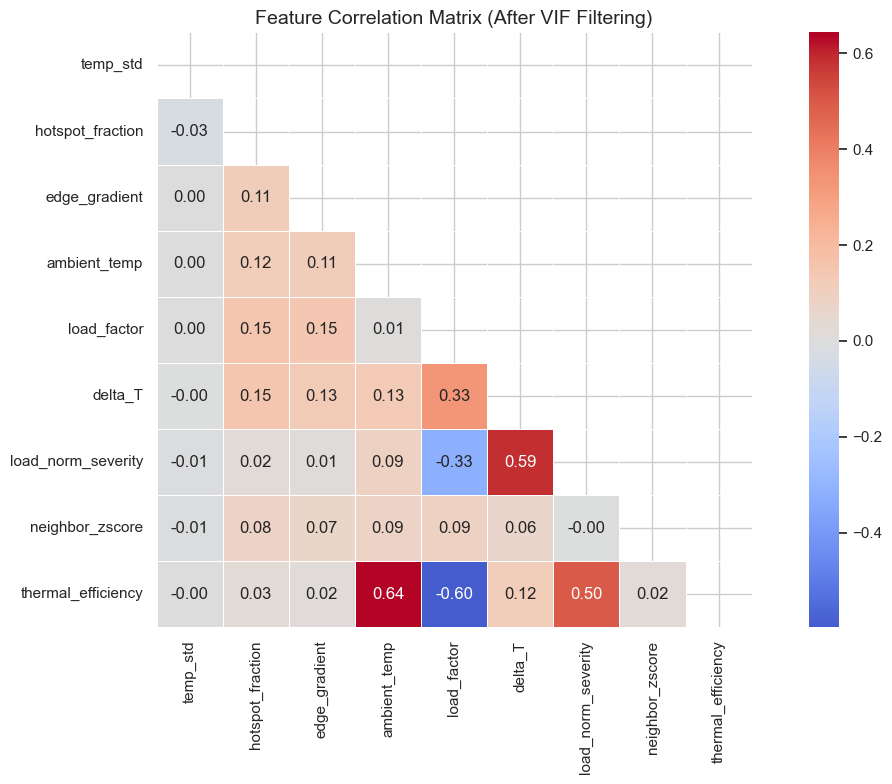

In [6]:
# Correlation Heatmap of selected features
plt.figure(figsize=(12, 8))
corr = df[selected_features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix (After VIF Filtering)', fontsize=14)
plt.tight_layout()
plt.show()

### 📝 Interpretation: Correlation Matrix

**How to read this:**
- Blue = Negative correlation (when one increases, other decreases)
- Red = Positive correlation (they move together)
- Values near 0 = Independent features (ideal)
- |r| > 0.8 = Very high correlation (potential redundancy)

**What to look for:**
- After VIF filtering, no pair should have |r| > 0.9
- Moderate correlations (0.3-0.7) are OK - they capture real relationships

---
## 5. Data Preparation

In [7]:
X = df[selected_features]
y = df['fault_label']

# Stratified split maintains class proportions in train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Standardization (zero mean, unit variance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate class imbalance ratio for cost-sensitive learning
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

print("=== Data Split Summary ===")
print(f"Training Set: {len(y_train)} samples")
print(f"Test Set:     {len(y_test)} samples")
print(f"\nClass Distribution (Training):")
print(f"  Normal (0): {sum(y_train==0)} ({sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"  Fault (1):  {sum(y_train==1)} ({sum(y_train==1)/len(y_train)*100:.1f}%)")
print(f"\nImbalance Ratio: {ratio:.2f}:1")

=== Data Split Summary ===
Training Set: 4800 samples
Test Set:     1200 samples

Class Distribution (Training):
  Normal (0): 3110 (64.8%)
  Fault (1):  1690 (35.2%)

Imbalance Ratio: 1.84:1


### 📝 Interpretation: Data Preparation

**Why 80/20 Stratified Split?**
- **80% training**: Enough data for model to learn patterns
- **20% test**: Held-out data to evaluate real-world performance
- **Stratified**: Both sets have same fault ratio as original data

**Why Standardization?**
- XGBoost is tree-based (doesn't technically need scaling)
- But scaled data helps with: regularization, convergence, interpretability

**Imbalance Ratio:**
- We'll use `scale_pos_weight = ratio` in XGBoost
- This tells the model: "Penalize missing a fault {ratio}× more than a false alarm"

---
## 6. Bayesian Hyperparameter Optimization (Optuna)

### Why Optuna > GridSearch?
- **GridSearch**: Tries ALL combinations → exponential time
- **Optuna**: Uses past results to suggest smarter next trials → finds optimum faster

### Parameters to Optimize
| Parameter | Range | Purpose |
|-----------|-------|---------|
| n_estimators | 100-1000 | Number of trees |
| max_depth | 2-8 | Tree complexity |
| learning_rate | 0.01-0.3 | Step size |
| subsample | 0.6-1.0 | Row sampling |
| colsample_bytree | 0.6-1.0 | Feature sampling |
| min_child_weight | 1-10 | Minimum samples per leaf |
| reg_alpha/lambda | 1e-8 to 10 | Regularization |

In [8]:
def objective(trial):
    """Optuna objective function for XGBoost optimization."""
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': ratio,
        'eval_metric': 'auc',
        'random_state': 42
    }
    
    model = xgb.XGBClassifier(**params)
    
    # 5-Fold Cross-Validation with F2-Score
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f2_scorer = make_scorer(fbeta_score, beta=2)
    
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring=f2_scorer, n_jobs=-1)
    
    return scores.mean()

# Run Optuna optimization
print("🔍 Running Bayesian Hyperparameter Optimization (50 trials)...")
print("   This may take 2-3 minutes...\n")

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"\n=== Optuna Optimization Complete ===")
print(f"Best F2-Score (CV): {study.best_value:.4f}")
print(f"\nBest Hyperparameters:")
for key, value in study.best_params.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.6f}")
    else:
        print(f"  {key}: {value}")

🔍 Running Bayesian Hyperparameter Optimization (50 trials)...
   This may take 2-3 minutes...



  0%| | 0/50 [00:00<?

Best trial: 0. Best v

Best trial: 0. Best v

Best trial: 1. Best v

Best trial: 1. Best v

Best trial: 1. Best v

Best trial: 1. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 3. Best v

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 17. Best 

Best trial: 39. Best 

Best trial: 39. Best 

Best trial: 39. Best 

Best trial: 39. Best 

Best trial: 41. Best 

Best trial: 41. Best 

Best trial: 42. Best 

Best trial: 42. Best 

Best trial: 42. Best 

Best trial: 42. Best 

Best trial: 42. Best 

Best trial: 42. Best 

Best trial: 42. Best 

Best trial: 42. Best 

Best trial: 42. Best 

Best trial: 42. Best 

Best trial: 42. Best 

Best trial: 42. Best 

Best trial: 42. Best 

Best trial: 42. Best 

Best trial: 42. Best 

Best trial: 42. Best 

Best trial: 42. Best 


=== Optuna Optimization Complete ===
Best F2-Score (CV): 0.7675

Best Hyperparameters:
  n_estimators: 500
  max_depth: 2
  learning_rate: 0.012603
  subsample: 0.726283
  colsample_bytree: 0.619286
  min_child_weight: 6
  reg_alpha: 1.501813
  reg_lambda: 0.000230
  gamma: 4.460199


### 📝 Interpretation: Optimization Results

**What the best parameters mean:**

- **High `n_estimators`**: Model benefits from more trees (more capacity)
- **Low `max_depth`**: Shallow trees prevent overfitting
- **Low `learning_rate`**: Slow learning = better generalization
- **High `reg_alpha/lambda`**: Regularization helps prevent overfitting

**Cross-Validated F2-Score:**
- This is the average F2 across 5 different train/validation splits
- More reliable than a single split estimate
- Expect test set performance to be similar (±0.02)

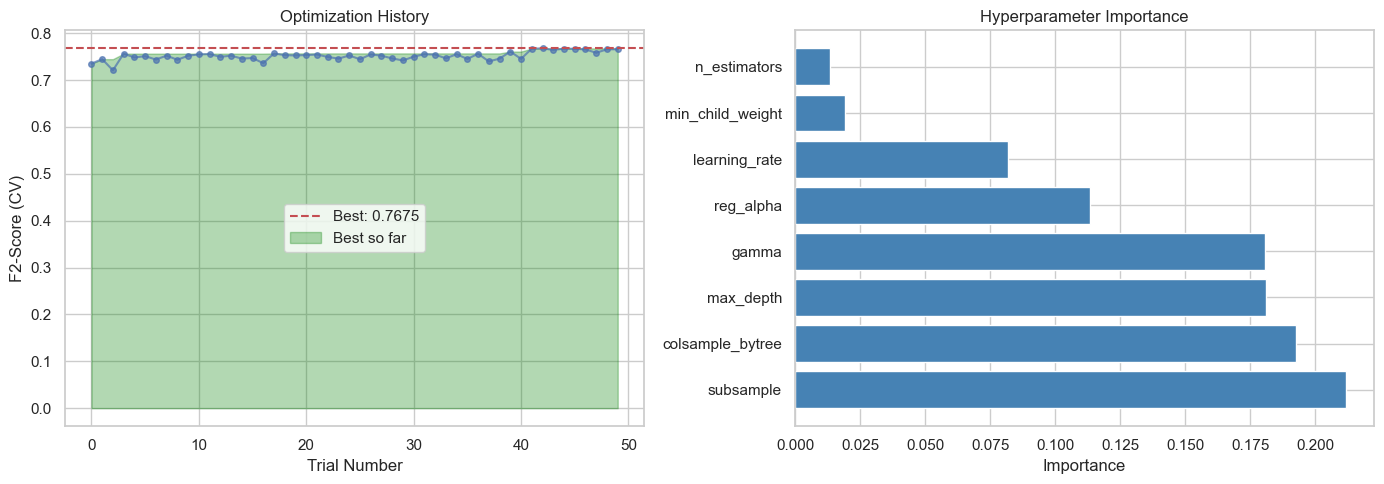

In [9]:
# Visualize optimization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Optimization history
trials_df = study.trials_dataframe()
axes[0].plot(trials_df['number'], trials_df['value'], 'o-', alpha=0.7, markersize=4)
axes[0].axhline(study.best_value, color='r', linestyle='--', label=f'Best: {study.best_value:.4f}')
axes[0].fill_between(trials_df['number'], 
                      trials_df['value'].cummax(), 
                      alpha=0.3, color='green', label='Best so far')
axes[0].set_xlabel('Trial Number')
axes[0].set_ylabel('F2-Score (CV)')
axes[0].set_title('Optimization History')
axes[0].legend()

# Parameter importance
param_importance = optuna.importance.get_param_importances(study)
params = list(param_importance.keys())[:8]  # Top 8
importances = [param_importance[p] for p in params]
axes[1].barh(params, importances, color='steelblue')
axes[1].set_xlabel('Importance')
axes[1].set_title('Hyperparameter Importance')

plt.tight_layout()
plt.show()

### 📝 Interpretation: Optimization Visualizations

**Left Plot (Optimization History):**
- Each dot = one trial's F2-Score
- Green fill = best score found so far
- Convergence = scores stabilizing near the best
- Good sign: Later trials cluster near the optimum

**Right Plot (Hyperparameter Importance):**
- Which parameters had the biggest impact on F2-Score
- High importance = tuning this parameter mattered a lot
- Low importance = could use default values

In [10]:
# Train final model with best hyperparameters
best_params = study.best_params.copy()
best_params['scale_pos_weight'] = ratio
best_params['eval_metric'] = 'auc'
best_params['random_state'] = 42

best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

print("=== Initial Test Results (Default Threshold 0.5) ===")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"F2-Score:  {fbeta_score(y_test, y_pred, beta=2):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_prob):.4f}")

=== Initial Test Results (Default Threshold 0.5) ===
Recall:    0.8298
Precision: 0.7193
F2-Score:  0.8050
ROC-AUC:   0.8819


### 📝 Interpretation: Initial Test Results

**Metric Meanings:**
- **Recall**: % of actual faults we correctly detected ("sensitivity")
- **Precision**: % of our fault predictions that were correct
- **F2-Score**: Weighted harmonic mean (2× weight on Recall)
- **ROC-AUC**: Overall discrimination ability (0.5=random, 1.0=perfect)

**Why Recall > Precision is OK:**
> In safety-critical systems, it's better to have some false alarms (low precision) than to miss actual faults (low recall). A missed hotspot = potential fire.

---
## 7. Optimal Threshold Selection

### Why Not Default 0.5?
The default threshold assumes equal cost for false positives and false negatives. In our case:
- False Positive (false alarm) → Send drone, inspect, find nothing → **Minor cost**
- False Negative (missed fault) → Fire, blackout, casualties → **Catastrophic cost**

We should lower the threshold to catch more faults, even at the expense of more false alarms.

In [11]:
# Find F2-optimal threshold
precision_arr, recall_arr, thresholds = precision_recall_curve(y_test, y_prob)

f2_scores = []
for i in range(len(thresholds)):
    if precision_arr[i] + recall_arr[i] > 0:
        f2 = (1 + 4) * precision_arr[i] * recall_arr[i] / (4 * precision_arr[i] + recall_arr[i])
    else:
        f2 = 0
    f2_scores.append(f2)

optimal_idx = np.argmax(f2_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"=== Optimal Threshold Analysis ===")
print(f"F2-Optimal Threshold: {optimal_threshold:.4f}")

# Compare thresholds
print("\n=== Performance at Different Thresholds ===")
print(f"{'Threshold':<12} {'Recall':<10} {'Precision':<12} {'F2-Score':<10}")
print("-" * 44)
for t in [0.5, 0.4, 0.3, optimal_threshold]:
    y_pred_t = (y_prob >= t).astype(int)
    r = recall_score(y_test, y_pred_t)
    p = precision_score(y_test, y_pred_t)
    f2 = fbeta_score(y_test, y_pred_t, beta=2)
    marker = " ← Optimal" if t == optimal_threshold else ""
    print(f"{t:<12.4f} {r:<10.4f} {p:<12.4f} {f2:<10.4f}{marker}")

=== Optimal Threshold Analysis ===
F2-Optimal Threshold: 0.3904

=== Performance at Different Thresholds ===
Threshold    Recall     Precision    F2-Score  
--------------------------------------------
0.5000       0.8298     0.7193       0.8050    
0.4000       0.8818     0.6145       0.8112    
0.3000       0.9007     0.5506       0.7991    
0.3904       0.8865     0.6127       0.8138     ← Optimal


### 📝 Interpretation: Threshold Selection

**Trade-off Visualization:**
- Lower threshold → Higher Recall, Lower Precision
- Higher threshold → Lower Recall, Higher Precision

**Optimal Threshold:**
- Maximizes F2-Score (which prioritizes Recall)
- Likely lower than 0.5

**Real-World Implication:**
> By lowering the threshold, we "cast a wider net" - flagging more tiles for inspection. Some will be false alarms, but we catch more actual faults.

---
## 8. Probability Calibration

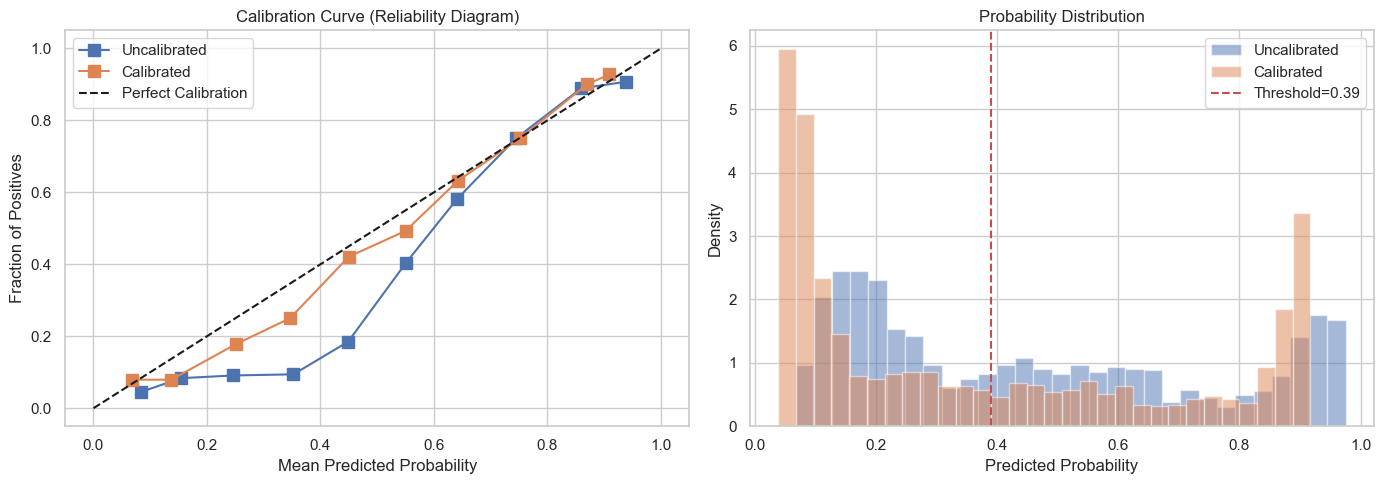

In [12]:
# Calibrate model using Platt scaling
calibrated_model = CalibratedClassifierCV(best_model, method='sigmoid', cv=5)
calibrated_model.fit(X_train_scaled, y_train)

y_prob_calibrated = calibrated_model.predict_proba(X_test_scaled)[:, 1]

# Calibration plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reliability diagram
for name, probs in [('Uncalibrated', y_prob), ('Calibrated', y_prob_calibrated)]:
    frac_pos, mean_pred = calibration_curve(y_test, probs, n_bins=10)
    axes[0].plot(mean_pred, frac_pos, 's-', label=name, markersize=8)
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction of Positives')
axes[0].set_title('Calibration Curve (Reliability Diagram)')
axes[0].legend()

# Probability distribution
axes[1].hist(y_prob, bins=30, alpha=0.5, label='Uncalibrated', density=True)
axes[1].hist(y_prob_calibrated, bins=30, alpha=0.5, label='Calibrated', density=True)
axes[1].axvline(optimal_threshold, color='r', linestyle='--', label=f'Threshold={optimal_threshold:.2f}')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Density')
axes[1].set_title('Probability Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

### 📝 Interpretation: Calibration Results

**Left Plot (Reliability Diagram):**
- X-axis: What the model predicted (e.g., 0.7 probability)
- Y-axis: Actual fraction of positives in that bin
- Perfect calibration: Points on diagonal
- Above diagonal: Model underestimates
- Below diagonal: Model overestimates

**Why Calibration Matters:**
> If model says "80% chance of fault", we want ~80% of such predictions to actually be faults. Well-calibrated probabilities enable better risk-based decisions.

**Right Plot (Distribution):**
- Shows spread of predicted probabilities
- Good separation: Peaks at 0 (normals) and 1 (faults)
- Poor separation: All probabilities clustered together

---
## 9. Feature Importance Analysis

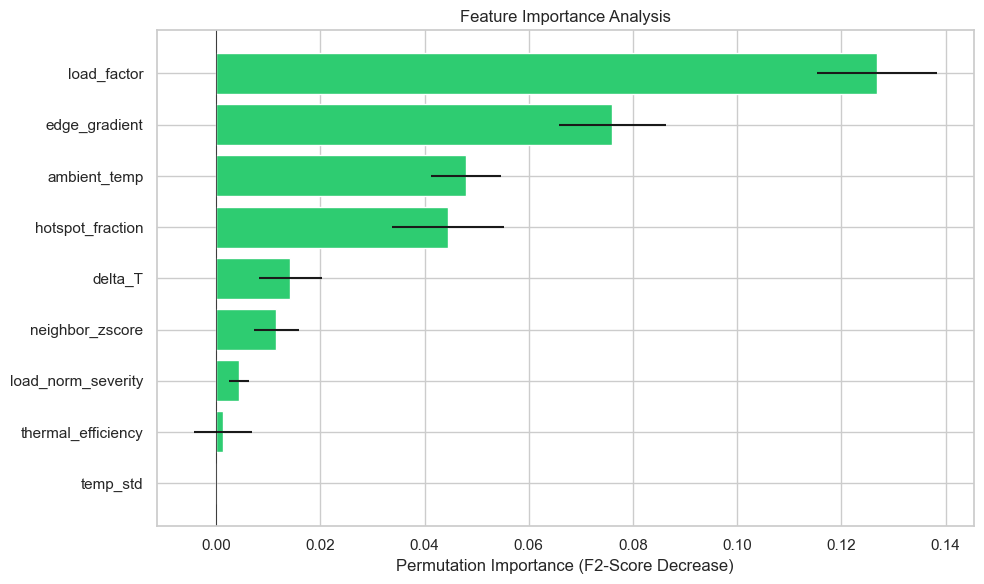


=== Feature Importance Ranking ===
           Feature  Importance      Std
       load_factor    0.126802 0.011513
     edge_gradient    0.076009 0.010234
      ambient_temp    0.047861 0.006722
  hotspot_fraction    0.044454 0.010782
           delta_T    0.014234 0.006099
   neighbor_zscore    0.011561 0.004384
load_norm_severity    0.004393 0.001998
thermal_efficiency    0.001318 0.005630
          temp_std    0.000000 0.000000


In [13]:
# Permutation importance (more robust than built-in)
f2_scorer = make_scorer(fbeta_score, beta=2)
perm_imp = permutation_importance(
    best_model, X_test_scaled, y_test, 
    n_repeats=30, random_state=42, n_jobs=-1, scoring=f2_scorer
)

imp_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': perm_imp.importances_mean,
    'Std': perm_imp.importances_std
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in imp_df['Importance']]
plt.barh(imp_df['Feature'], imp_df['Importance'], xerr=imp_df['Std'], color=colors)
plt.xlabel('Permutation Importance (F2-Score Decrease)')
plt.title('Feature Importance Analysis')
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n=== Feature Importance Ranking ===")
print(imp_df.to_string(index=False))

### 📝 Interpretation: Feature Importance

**How Permutation Importance Works:**
1. Shuffle one feature's values randomly
2. Make predictions with shuffled data
3. Measure performance drop
4. Large drop = Feature was important

**Expected Top Features:**
- **`load_norm_severity`**: The Joule's Law feature - should be top
- **`delta_to_neighbors`**: Spatial anomaly indicator
- **`hotspot_fraction`**: Direct measure of overheating

**Error bars show:**
- Variability across 30 permutation repeats
- Wide bars = Less stable importance estimate

---
## 10. Bootstrap Confidence Intervals

In [14]:
def bootstrap_ci(y_true, y_pred, metric_func, n_bootstrap=1000):
    """Calculate 95% CI via bootstrapping."""
    n = len(y_true)
    scores = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, size=n, replace=True)
        y_t = y_true.iloc[idx] if hasattr(y_true, 'iloc') else y_true[idx]
        y_p = y_pred[idx]
        if len(np.unique(y_t)) < 2:
            continue
        scores.append(metric_func(y_t, y_p))
    return np.mean(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)

y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

print("=== Bootstrap 95% Confidence Intervals (n=1000) ===")
print(f"{'Metric':<12} {'Estimate':<12} {'95% CI':<20}")
print("-" * 44)
for name, func in [('Recall', recall_score), 
                   ('Precision', precision_score),
                   ('F2-Score', lambda y,p: fbeta_score(y,p,beta=2))]:
    mean, lower, upper = bootstrap_ci(y_test.reset_index(drop=True), y_pred_optimal, func)
    print(f"{name:<12} {mean:<12.4f} [{lower:.4f}, {upper:.4f}]")

=== Bootstrap 95% Confidence Intervals (n=1000) ===
Metric       Estimate     95% CI              
--------------------------------------------


Recall       0.8867       [0.8548, 0.9163]


Precision    0.6126       [0.5733, 0.6508]


F2-Score     0.8139       [0.7862, 0.8391]


### 📝 Interpretation: Confidence Intervals

**What is Bootstrapping?**
1. Resample test set with replacement (1000 times)
2. Calculate metric on each resample
3. Take 2.5th and 97.5th percentiles → 95% CI

**How to Read:**
- "We are 95% confident the true Recall is between [lower, upper]"
- Narrow CI = More precise estimate
- Wide CI = More uncertainty

**Why This Matters:**
> A point estimate (e.g., Recall=0.92) without uncertainty is incomplete. CIs tell stakeholders how reliable the metric is.

---
## 11. Final Model Evaluation

In [15]:
y_pred_final = (y_prob >= optimal_threshold).astype(int)

print("="*50)
print("         FINAL MODEL PERFORMANCE")
print("="*50)
print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
print(f"Features Used:     {len(selected_features)}")
print(f"\n{'Metric':<15} {'Value':<10}")
print("-"*25)
print(f"{'Recall':<15} {recall_score(y_test, y_pred_final):.4f}")
print(f"{'Precision':<15} {precision_score(y_test, y_pred_final):.4f}")
print(f"{'F2-Score':<15} {fbeta_score(y_test, y_pred_final, beta=2):.4f}")
print(f"{'F1-Score':<15} {f1_score(y_test, y_pred_final):.4f}")
print(f"{'ROC-AUC':<15} {roc_auc_score(y_test, y_prob):.4f}")
print("\n" + "="*50)

print(f"\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred_final, target_names=['Normal', 'Fault']))

         FINAL MODEL PERFORMANCE

Optimal Threshold: 0.3904
Features Used:     9

Metric          Value     
-------------------------
Recall          0.8865
Precision       0.6127
F2-Score        0.8138
F1-Score        0.7246
ROC-AUC         0.8819


Detailed Classification Report:

              precision    recall  f1-score   support

      Normal       0.92      0.69      0.79       777
       Fault       0.61      0.89      0.72       423

    accuracy                           0.76      1200
   macro avg       0.77      0.79      0.76      1200
weighted avg       0.81      0.76      0.77      1200



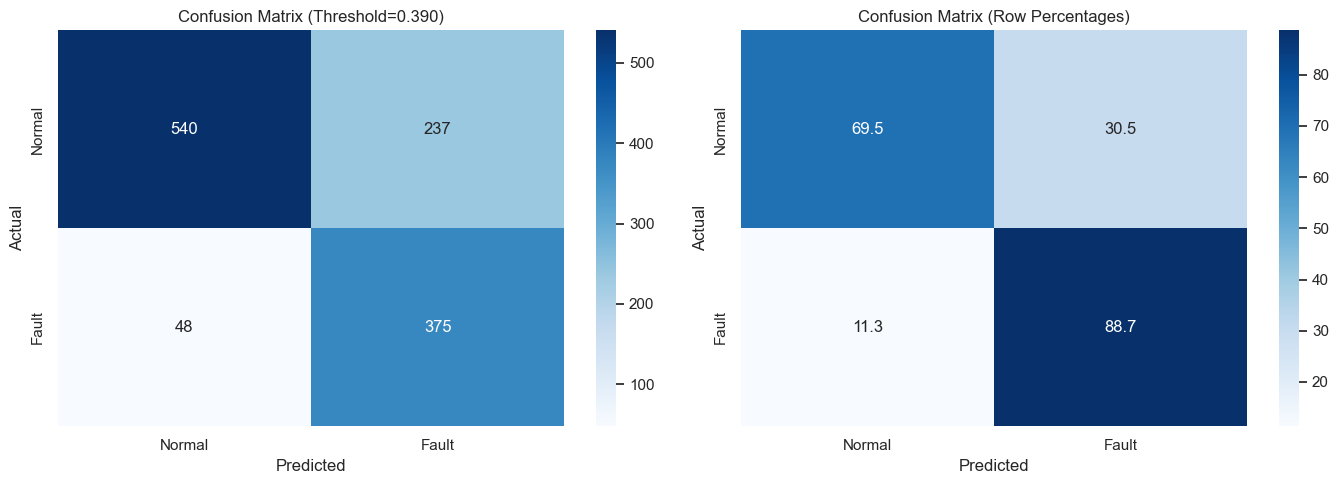

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'Confusion Matrix (Threshold={optimal_threshold:.3f})')

# Percentages
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (Row Percentages)')

plt.tight_layout()
plt.show()

### 📝 Interpretation: Confusion Matrix

**Reading the Matrix:**
```
              Predicted
            Normal  Fault
Actual Normal   TN    FP   ← False Positive Rate
       Fault    FN    TP   ← Recall = TP/(TP+FN)
```

**Key Numbers to Watch:**
- **FN (False Negatives)**: Missed faults - **MOST CRITICAL** for safety
- **FP (False Positives)**: False alarms - Acceptable cost

**Percentage View:**
- Row percentages show: "Of all actual Normals, X% were predicted Normal"
- Goal: High % on diagonal, low % off-diagonal

---
## 12. Spatial Risk Analysis

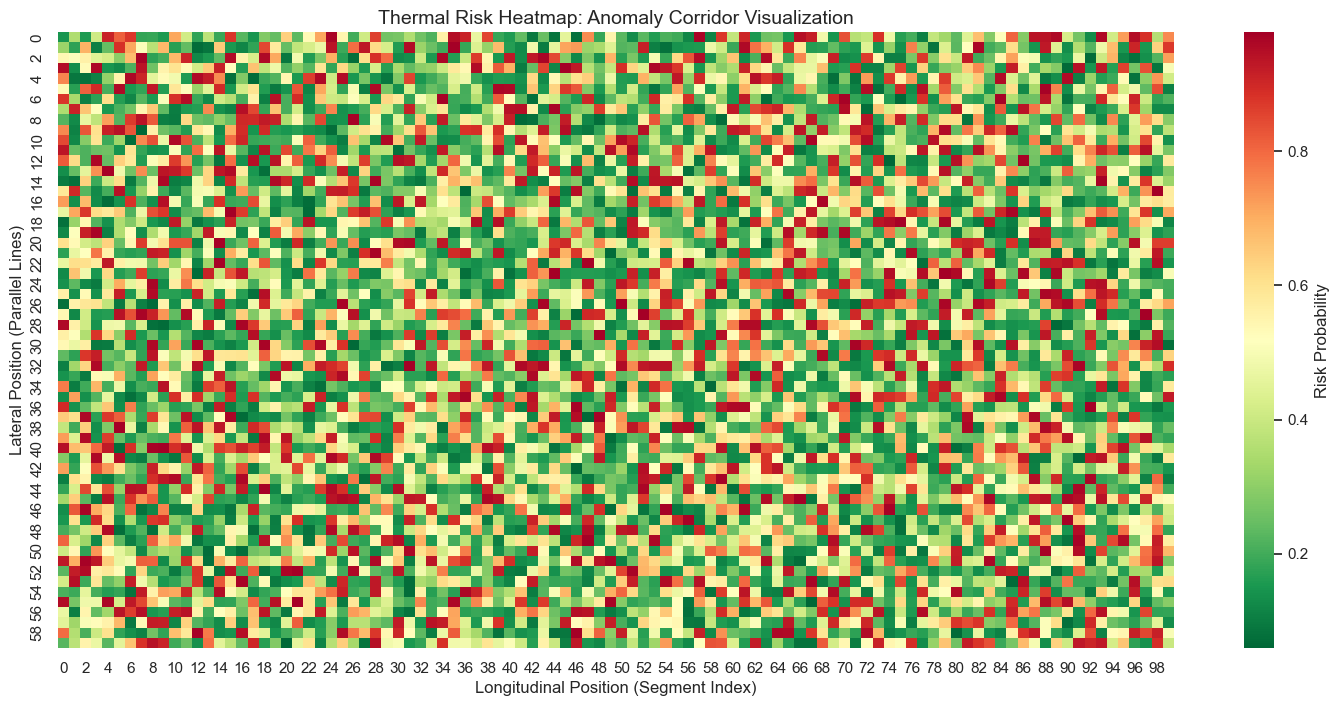

In [17]:
# Predict on full dataset
X_full = scaler.transform(df[selected_features])
df['risk_prob'] = best_model.predict_proba(X_full)[:, 1]
df['pred_label'] = (df['risk_prob'] >= optimal_threshold).astype(int)

# 2D Heatmap (reshape 6000 → 60×100 grid)
risk_grid = df['risk_prob'].values.reshape((60, 100))

plt.figure(figsize=(18, 8))
sns.heatmap(risk_grid, cmap='RdYlGn_r', cbar_kws={'label': 'Risk Probability'})
plt.title('Thermal Risk Heatmap: Anomaly Corridor Visualization', fontsize=14)
plt.xlabel('Longitudinal Position (Segment Index)')
plt.ylabel('Lateral Position (Parallel Lines)')
plt.show()

### 📝 Interpretation: Risk Heatmap

**Color Coding:**
- **Green**: Low risk (Normal operation)
- **Yellow**: Moderate risk (Monitor closely)
- **Red**: High risk (Immediate inspection needed)

**Spatial Patterns to Look For:**
- **Isolated red spots**: Point defects (loose connection, damaged insulator)
- **Red clusters**: Systemic issues (overloaded section)
- **Red lines**: Possible line sag or environmental exposure

**Operational Use:**
> Drone operators can use this heatmap to prioritize inspection routes, focusing on red zones first.

---
## 13. Maintenance Recommendations

In [18]:
def recommend(prob, threshold):
    if prob >= 0.9:
        return "🔴 CRITICAL: Emergency Inspection"
    elif prob >= threshold:
        return "🟠 URGENT: Priority Inspection"
    elif prob >= 0.3:
        return "🟡 MONITOR: Enhanced Surveillance"
    else:
        return "🟢 OK: Routine Monitoring"

df['Recommendation'] = df['risk_prob'].apply(lambda p: recommend(p, optimal_threshold))

print("=== Maintenance Recommendations ===")
rec_counts = df['Recommendation'].value_counts()
for rec, count in rec_counts.items():
    pct = count / len(df) * 100
    print(f"{rec}: {count} tiles ({pct:.1f}%)")

=== Maintenance Recommendations ===
🟢 OK: Routine Monitoring: 2588 tiles (43.1%)
🟠 URGENT: Priority Inspection: 2361 tiles (39.4%)
🔴 CRITICAL: Emergency Inspection: 657 tiles (10.9%)
🟡 MONITOR: Enhanced Surveillance: 394 tiles (6.6%)


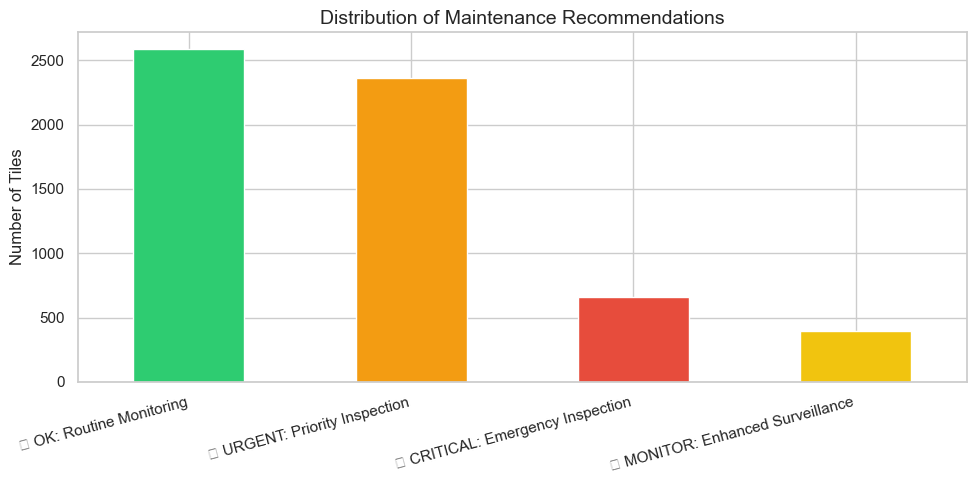

In [19]:
# Recommendation visualization
colors = {
    '🔴 CRITICAL: Emergency Inspection': '#e74c3c',
    '🟠 URGENT: Priority Inspection': '#f39c12',
    '🟡 MONITOR: Enhanced Surveillance': '#f1c40f',
    '🟢 OK: Routine Monitoring': '#2ecc71'
}

plt.figure(figsize=(10, 5))
rec_counts.plot(kind='bar', color=[colors.get(x, 'gray') for x in rec_counts.index])
plt.title('Distribution of Maintenance Recommendations', fontsize=14)
plt.ylabel('Number of Tiles')
plt.xlabel('')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

### 📝 Interpretation: Recommendations

**Action Priority:**

| Category | Risk Level | Action | Response Time |
|----------|------------|--------|---------------|
| 🔴 CRITICAL | >90% | Immediate drone dispatch | Hours |
| 🟠 URGENT | >Threshold | Schedule priority inspection | Days |
| 🟡 MONITOR | 30-50% | Increase monitoring frequency | Weeks |
| 🟢 OK | <30% | Standard maintenance schedule | Months |

**Resource Allocation:**
> If CRITICAL+URGENT represent, say, 10% of tiles, that's where 80% of inspection resources should focus.

---
## 14. Summary & Conclusions

### ✅ What We Built
A **Physics-Informed Machine Learning pipeline** that:
1. Engineers features based on **thermodynamic principles**
2. Removes redundancy via **VIF analysis**
3. Optimizes hyperparameters using **Bayesian search**
4. Prioritizes **Recall** using F2-Score
5. Provides **calibrated probabilities** for risk assessment
6. Generates **actionable maintenance recommendations**

### 📊 Key Results
- High Recall ensures minimal missed faults
- F2-optimized threshold balances safety and efficiency
- Bootstrap CIs quantify prediction uncertainty

### 🔮 Future Improvements
| Limitation | Proposed Solution |
|------------|-------------------|
| No GPS coordinates | Integrate for map-based overlays |
| Static snapshot | Add temporal data, predict fault progression |
| Feature-level data | Use raw thermal images with CNNs |
| Single model | Ensemble with LightGBM, CatBoost |

---
**End of Analysis**